# Environment Setup and Data Loading

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import os
import sys
import anndata as ad
import random
import importlib

PROJECT_DIR = "D:/Github/SRF_Linda_RNA"
WORKING_DIR = os.path.join(PROJECT_DIR, "combine_data")
LIB_DIRS = os.path.join(WORKING_DIR, "LIBRARIES")
os.chdir(WORKING_DIR)
sys.path.insert(0, WORKING_DIR)
sys.path.insert(0, LIB_DIRS)

# Set seeds for all random number generators
random_seed = 0
np.random.seed(random_seed)
random.seed(random_seed)

In [5]:
DATA_DIR = os.path.join(WORKING_DIR, "results_from_raw")
adata_path = os.path.join(DATA_DIR, 'annotation_final.h5ad')

PATHWAYS_DIR = os.path.join(WORKING_DIR, "ANALYSIS", "6_Pathways_Analysis")

In [6]:
# Load data
print(f"\nLoading dataset from {adata_path}")
adata = sc.read_h5ad(adata_path)


Loading dataset from D:/Github/SRF_Linda_RNA\combine_data\results_from_raw\annotation_final.h5ad


# Visualize Apoptosis Pathway Gene Expression

In [7]:
# Gene set for WP_APOPTOSIS (Mus musculus) from WikiPathways WP1254
# https://www.wikipathways.org/pathways/WP1254

with open(os.path.join(PATHWAYS_DIR, 'WP_APOPTOSIS.v2025.1.Mm.grp'), 'r') as f:
    # Skip the first line (pathway name) and read the rest of the genes
    apoptosis_genes = [line.strip() for line in f.readlines()[1:] if line.strip()]

# Check which genes are present in the anndata object
apoptosis_genes_in_adata = [gene for gene in apoptosis_genes if gene in adata.var_names]
print(f"Found {len(apoptosis_genes_in_adata)} out of {len(apoptosis_genes)} apoptosis genes in the dataset.")
print(apoptosis_genes)

Found 77 out of 78 apoptosis genes in the dataset.
['Akt1', 'Apaf1', 'Bad', 'Bax', 'Bcl2', 'Bcl2l1', 'Bcl2l11', 'Bcl2l2', 'Bid', 'Birc2', 'Birc3', 'Birc5', 'Bnip3l', 'Bok', 'Casp1', 'Casp2', 'Casp3', 'Casp4', 'Casp6', 'Casp7', 'Casp8', 'Casp9', 'Cflar', 'Chuk', 'Cradd', 'Dffa', 'Dffb', 'Diablo', 'Fas', 'Fasl', 'Gzmc', 'Hells', 'Hrk', 'Igf1', 'Igf1r', 'Igf2', 'Ikbkb', 'Ikbkg', 'Irf1', 'Irf2', 'Irf3', 'Irf4', 'Irf5', 'Irf6', 'Irf7', 'Jun', 'Lta', 'Map2k4', 'Map3k1', 'Mapk10', 'Mcl1', 'Mdm2', 'Myc', 'Nfkb1', 'Nfkbia', 'Nfkbib', 'Nfkbie', 'Pik3r1', 'Pmaip1', 'Prf1', 'Rela', 'Ripk1', 'Scaf11', 'Tnf', 'Tnfrsf10b', 'Tnfrsf1a', 'Tnfrsf1b', 'Tnfrsf21', 'Tnfrsf25', 'Tnfsf10', 'Tradd', 'Traf1', 'Traf2', 'Traf3', 'Trp53', 'Trp63', 'Trp73', 'Xiap']


In [8]:
# Calculate the score for the apoptosis gene set
ctrl_size = min(50, len(apoptosis_genes_in_adata) - 1)
sc.tl.score_genes(adata, gene_list=apoptosis_genes_in_adata, score_name='apoptosis_score', ctrl_size=ctrl_size)
# Normalize and scale the apoptosis score (z-score normalization)
score = adata.obs["apoptosis_score"]
# adata.obs["apoptosis_score"] = (score - score.mean()) / score.std()
# adata.obs["apoptosis_score"] = np.sign(score) * np.power(score, 4)
max_score = adata.obs.apoptosis_score.max()
min_score = adata.obs.apoptosis_score.min()
print(f"max apoptosis score: {max_score}")
print(f"min apoptosis score: {min_score}")

max apoptosis score: 1.4910714285714284
min apoptosis score: -2.2113452585150695


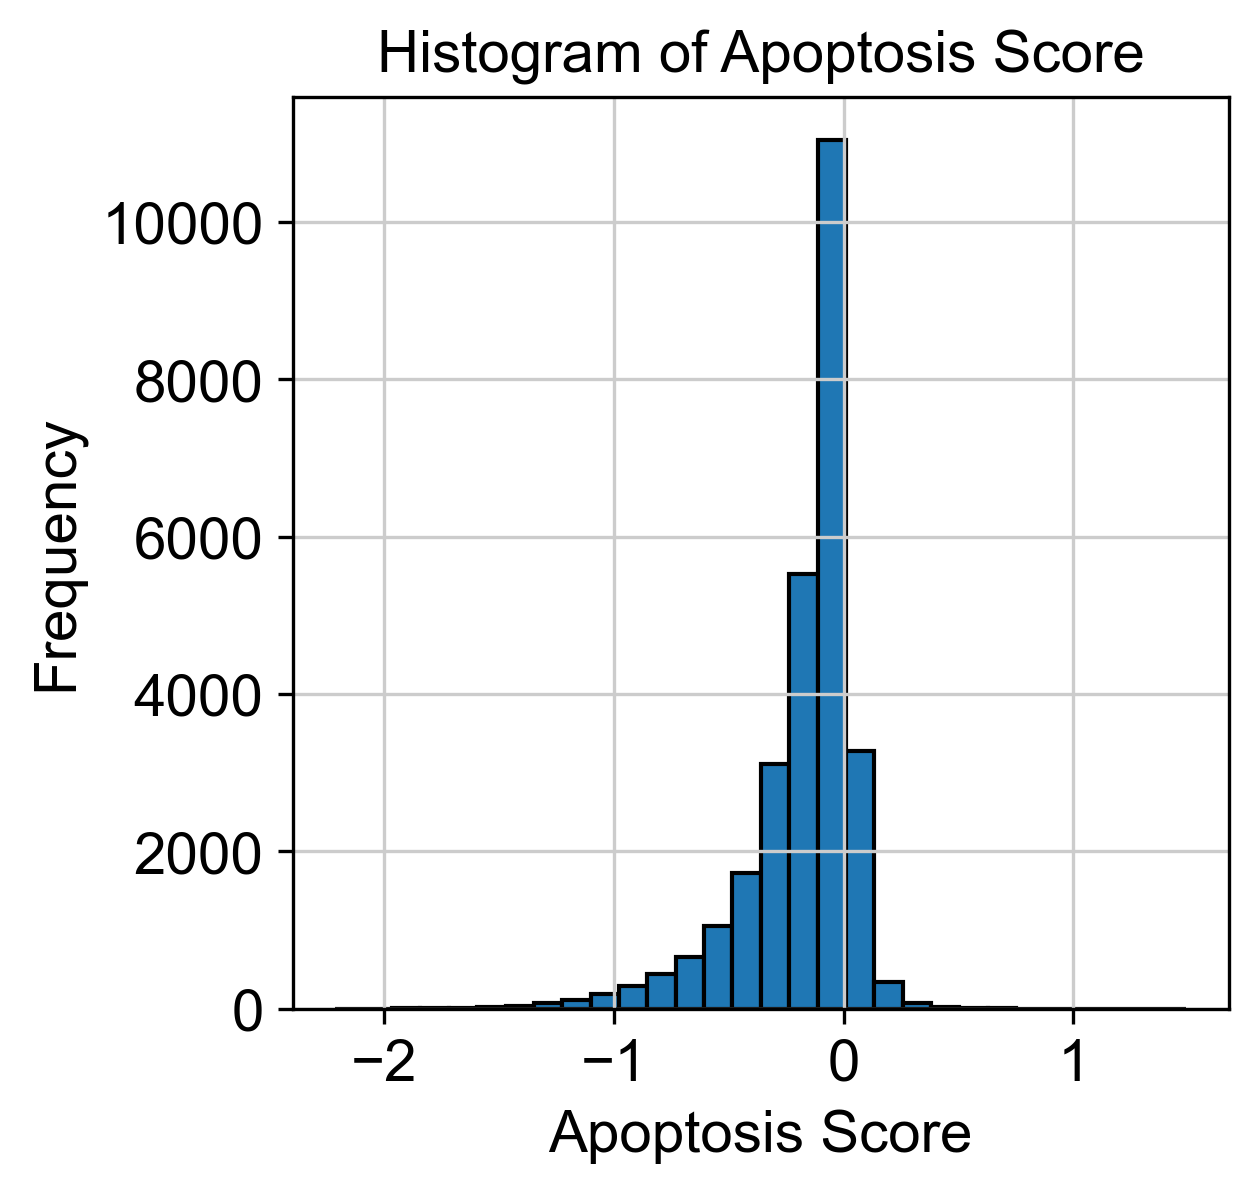

In [9]:
import matplotlib.pyplot as plt
plt.hist(adata.obs.apoptosis_score, bins=30, edgecolor='black')
plt.xlabel("Apoptosis Score")
plt.ylabel("Frequency")
plt.title("Histogram of Apoptosis Score")
plt.show()

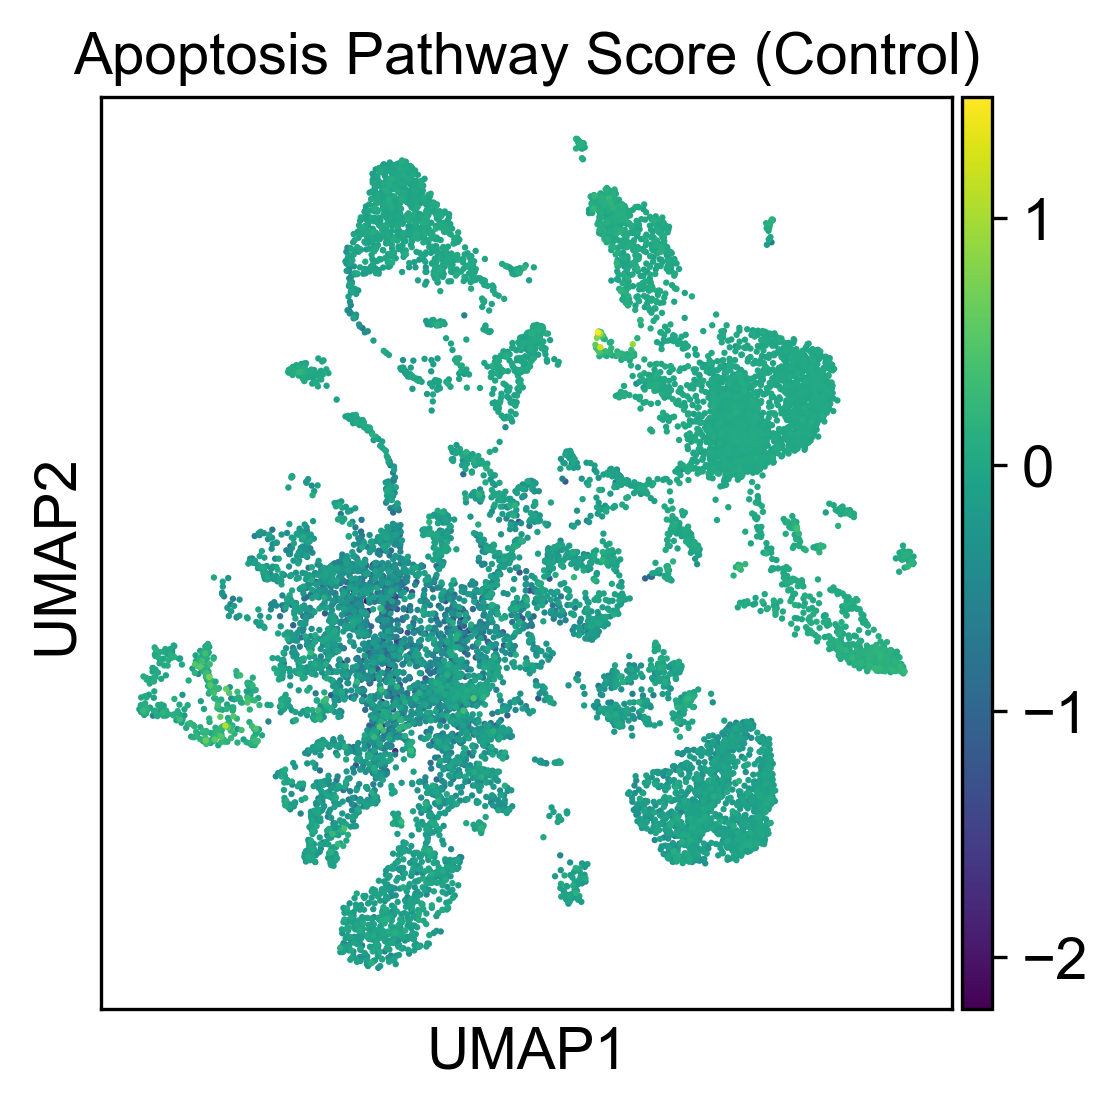

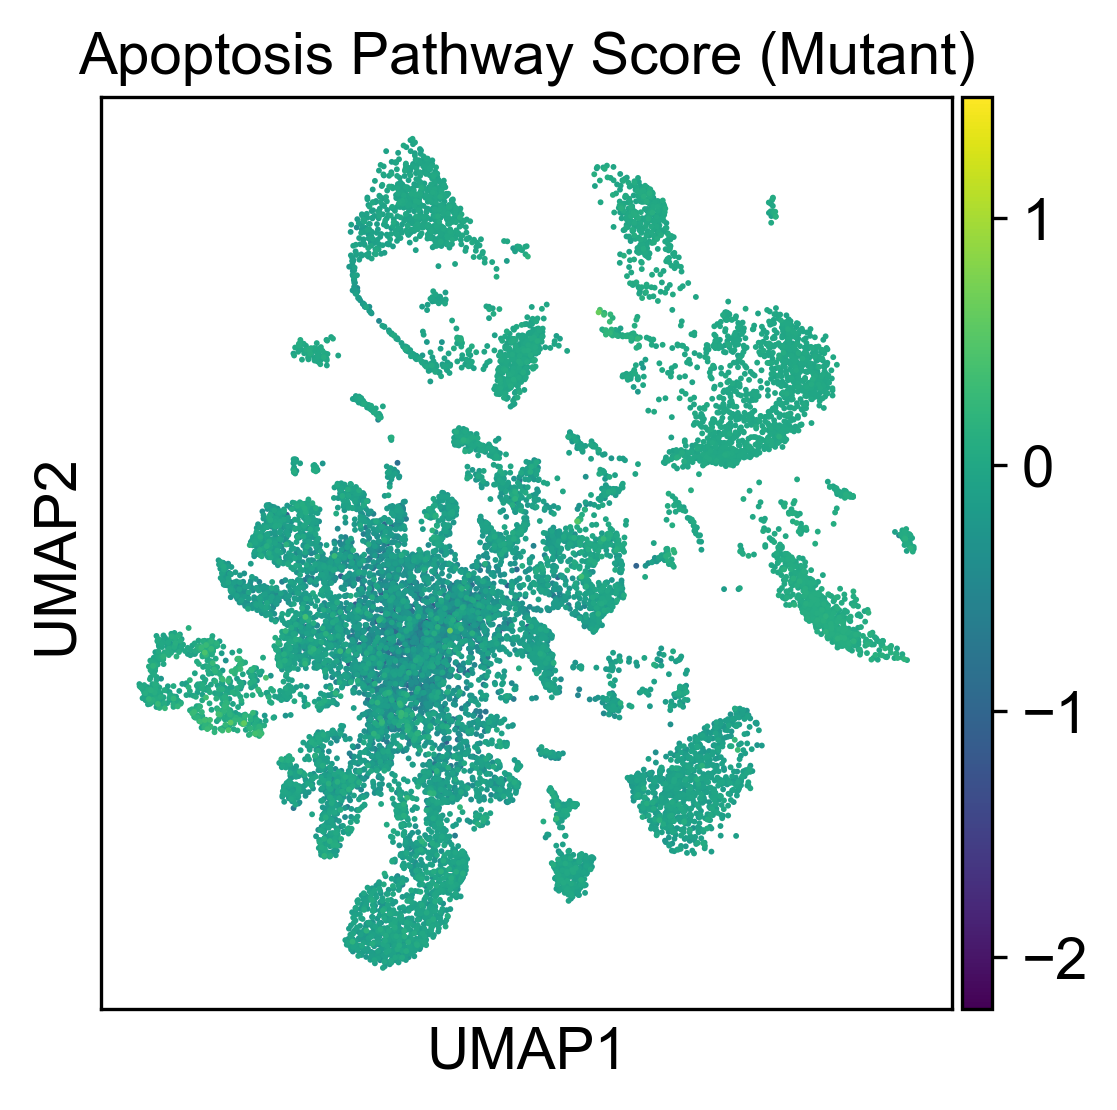

In [10]:
# Plot the score on the UMAP for Control cells
sc.pl.umap(
    adata[adata.obs.condition == "Control"],
    color='apoptosis_score',
    cmap='viridis',
    vmin=min_score,
    vmax=max_score,
    title='Apoptosis Pathway Score (Control)',
    save='apoptosis_score_control.png'
)

# Plot the score on the UMAP for Mutant cells
sc.pl.umap(
    adata[adata.obs.condition == "Mutant"],
    color='apoptosis_score',
    cmap='viridis',
    vmin=min_score,
    vmax=max_score,
    title='Apoptosis Pathway Score (Mutant)',
    save='apoptosis_score_mutant.png'
)

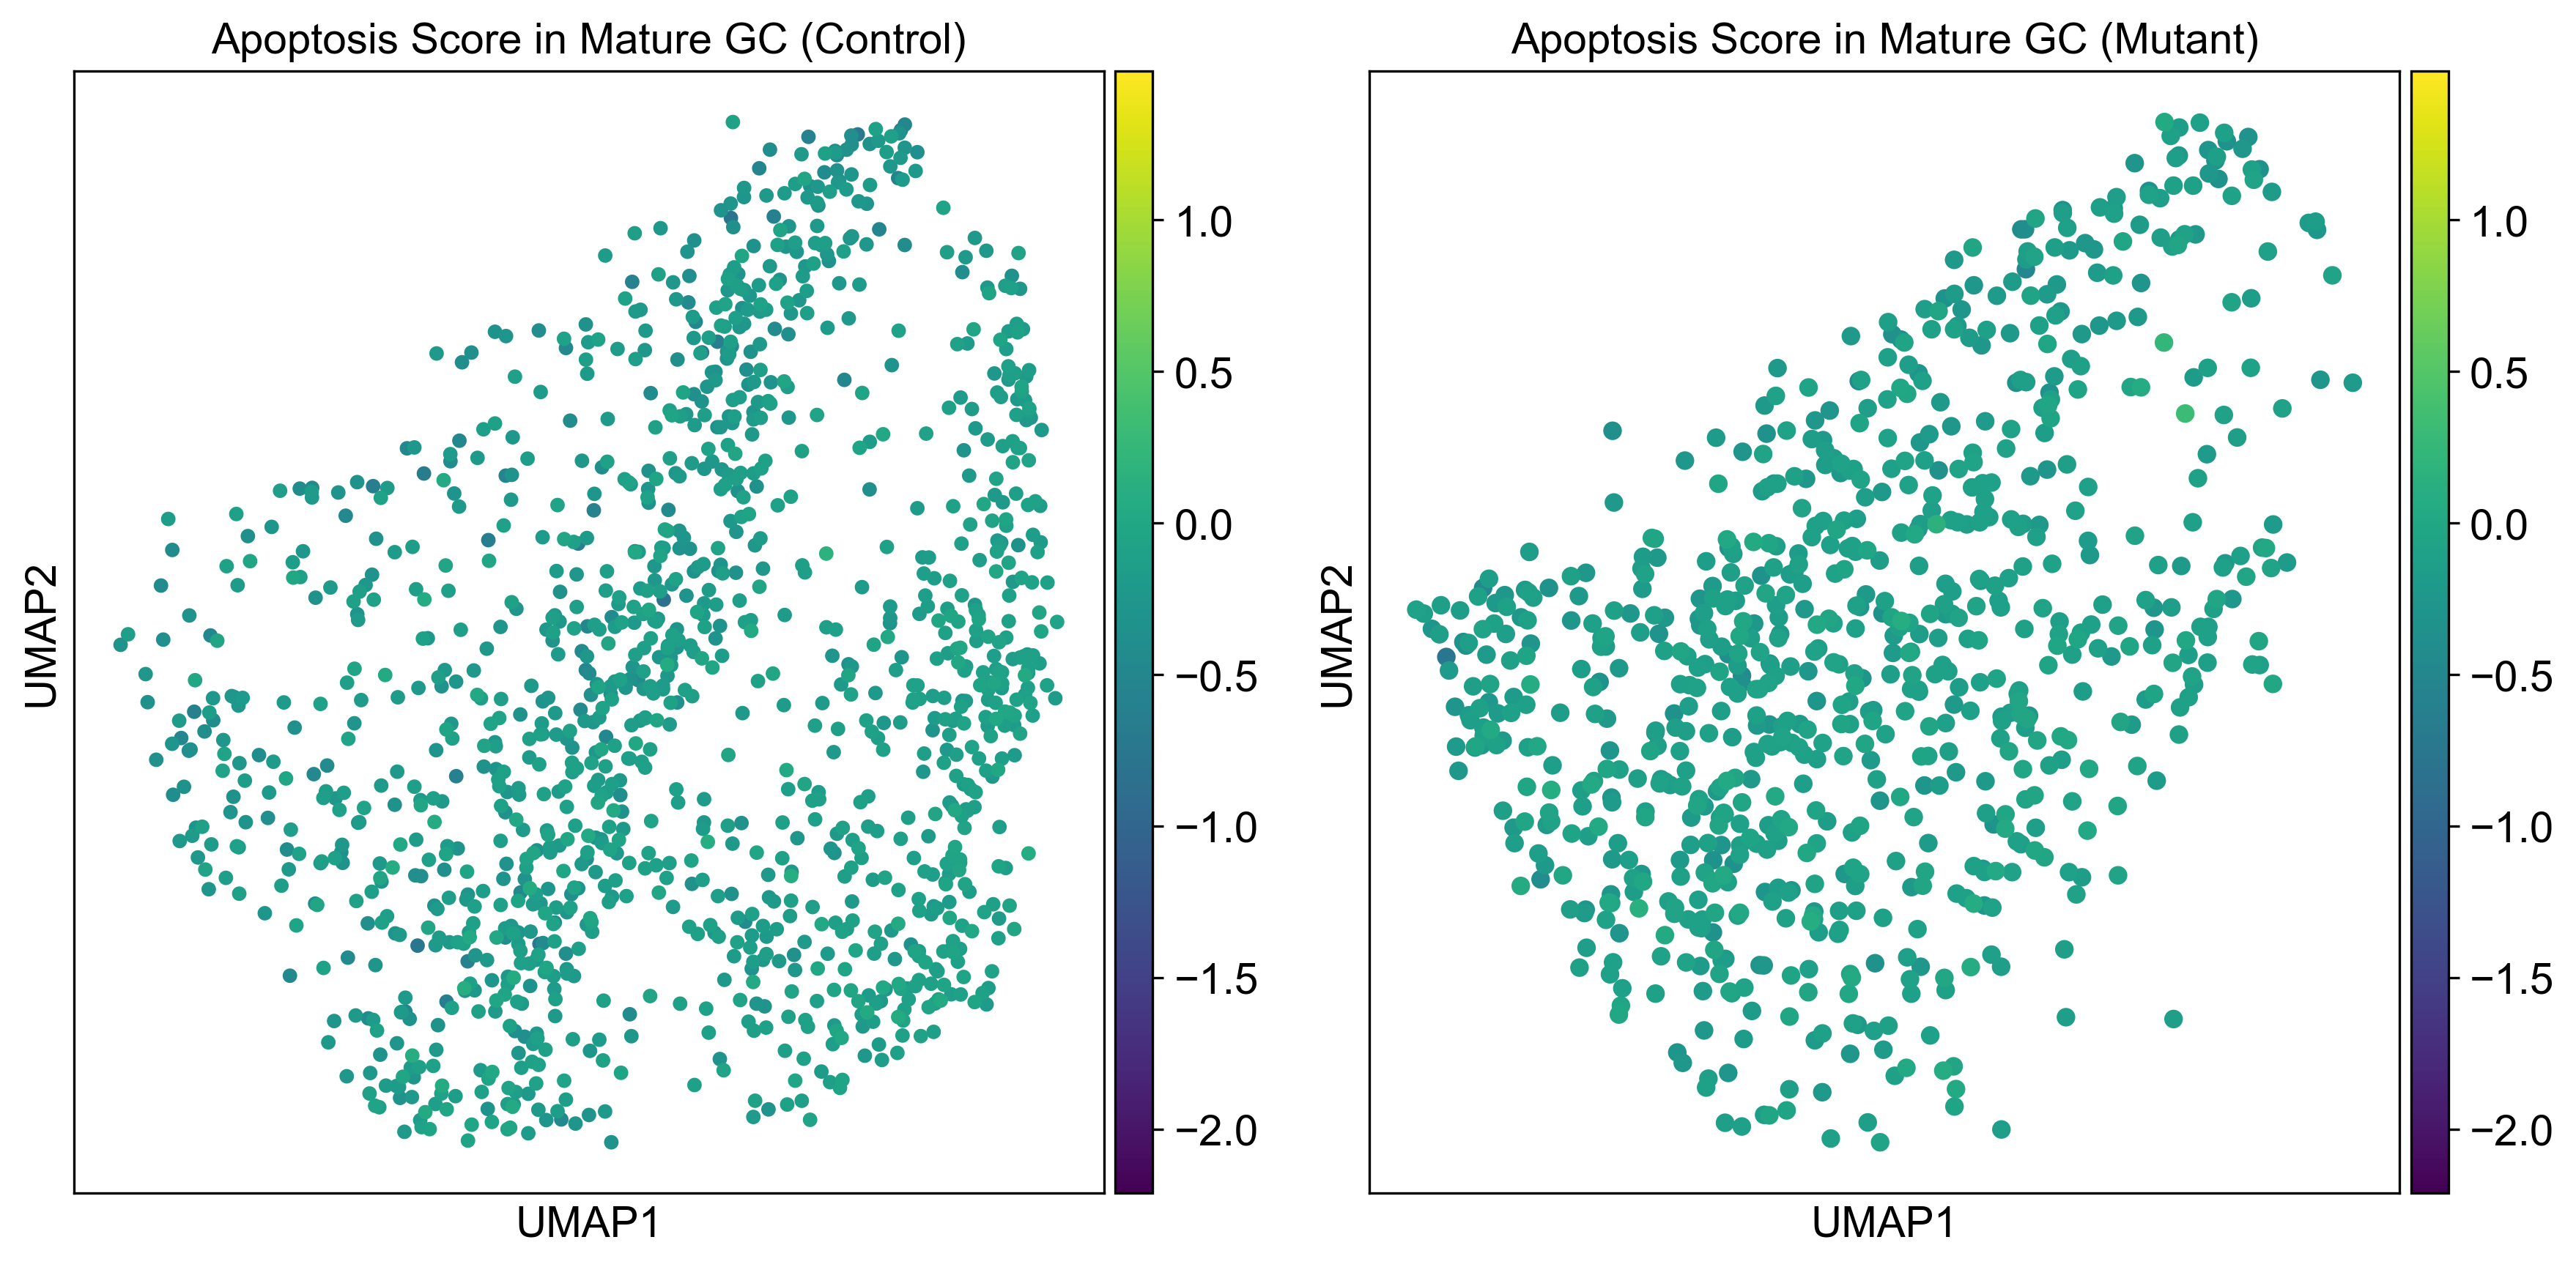

In [13]:
# Compare the apoptosis score between Control and Mutant in Mature GC cell types by plotting them side‐by‐side.
gc_mature_data = adata[adata.obs.cell_type_L2_new == "Mature GC"]

import matplotlib.pyplot as plt

# Create subplots for Control and Mutant conditions
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Filter the GC_Mature cells by condition
control_data = gc_mature_data[gc_mature_data.obs.condition == "Control"]
mutant_data = gc_mature_data[gc_mature_data.obs.condition == "Mutant"]

# Plot UMAP for Control cells
sc.pl.umap(
    control_data,
    color='apoptosis_score',
    cmap='viridis',
    vmin=min_score,
    vmax=max_score,
    title='Apoptosis Score in Mature GC (Control)',
    ax=axes[0],
    show=False
)

# Plot UMAP for Mutant cells
sc.pl.umap(
    mutant_data,
    color='apoptosis_score',
    cmap='viridis',
    vmin=min_score,
    vmax=max_score,
    title='Apoptosis Score in Mature GC (Mutant)',
    ax=axes[1],
    show=False
)

plt.tight_layout()
# plt.savefig('apoptosis_score_gc_mature.png')
plt.show()

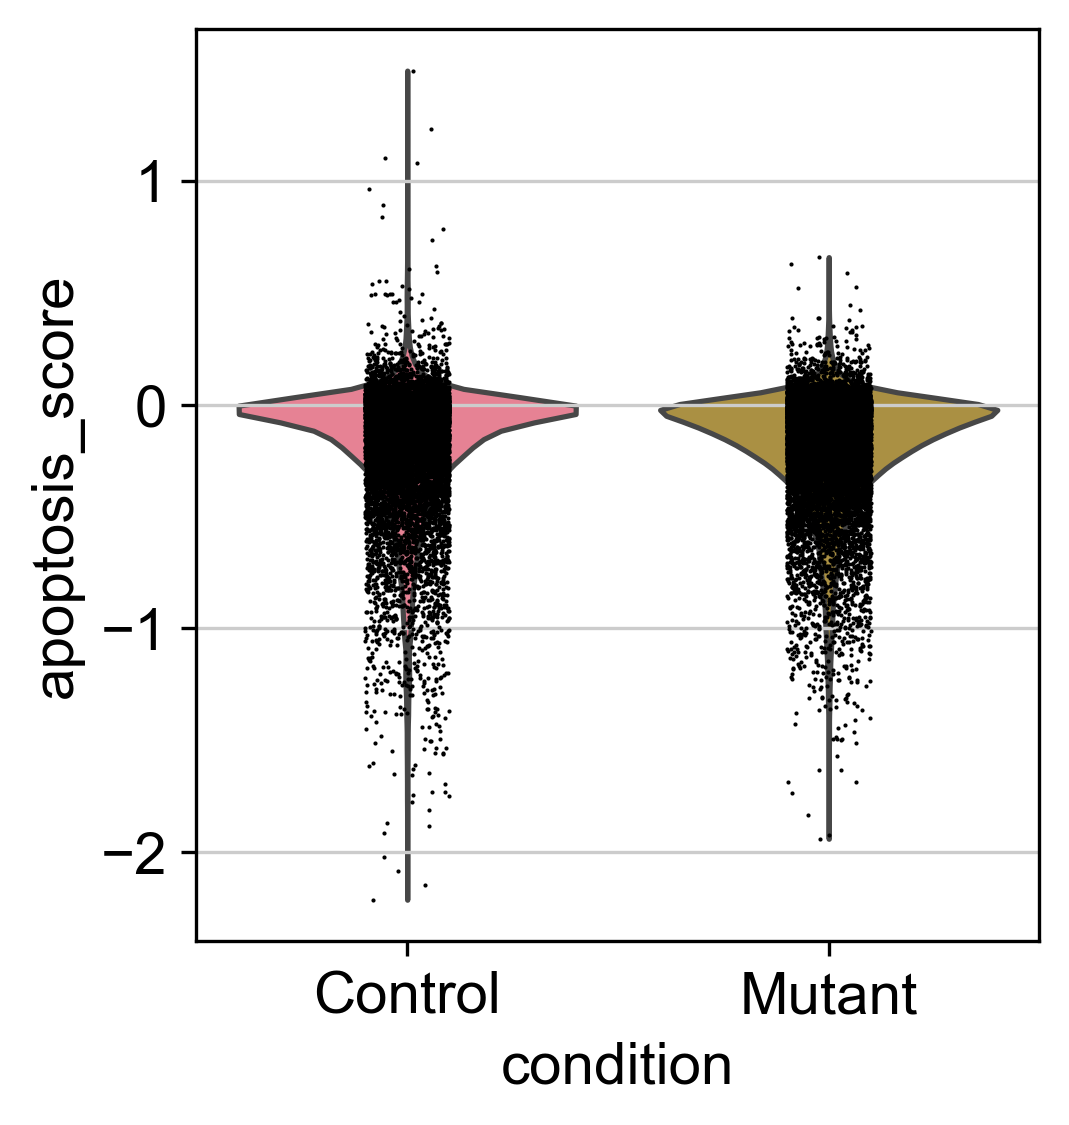

In [14]:
sc.pl.violin(adata, 'apoptosis_score', groupby='condition')